In [167]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import linear_model
from sklearn.model_selection import train_test_split

### Converting Description to Number of Pounds

In [5]:
food = pd.read_csv("replate_reduced.csv")
#dropping rows that don't contain any results or numbers in description 
food = food[food["Description"].str.contains("\d")]
food["Description"] = food["Description"].str.lower()
#dropping rows that didn't have food to pickup 
food = food[food["Description"].str.contains("no food") == False]
pd.options.display.max_colwidth = 500
#looked at inputs where the number of pounds wasn't listed first
food[food["Description"].str.match("^\d") == False][["Id", "Description"]].iloc[149:, :]
#inputs with these ids didn't have number of pounds for pickup
delete_id = [465, 492, 552, 635, 649, 750, 822, 907, 1002, 1029, 
             1030, 1031, 1055, 1058, 1280, 1750, 1756, 1812, 1862, 
             1976, 2351, 2452, 2586, 2751, 3565, 5051, 603, 1783, 
             2364, 2760, 3050, 3051, 3139, 3563, 3585, 3897, 5398, 
             5814, 6072, 6142, 6666]
food = food[food["Id"].isin(delete_id) == False]
#food.to_csv("replate_updated_updated.csv", sep = ",")

In [6]:
#look at each of the character in description and identify whether it's a 
#number, will take into account whether or not it's a decimal number
splitted = food["Description"].str.extractall("(\d*\.?\d*)").unstack()
for col in splitted:
    #convert string to float, otherwise will just be nan
    splitted[col] = pd.to_numeric(splitted[col], errors = "coerce")
#take the maximum float for each of the inputs 
max_pounds = splitted.fillna(0.0).apply(max, axis = 1)
food["Description"] = max_pounds
food = food.replace({"-": np.nan}, regex = True)
food = food.drop(["Unnamed: 0", "Short", "Plan [Location]", "Paid"], axis = 1)
food = food.rename(index = str, columns = {"Description": "pounds", "Scheduled date": "date",
                                          "City [Location]": "city", "State [Location]": "state",
                                          "Zip [Location]": "zip", "Pickup price [Location]": "pickup",
                                          "Plan exclusive [Location]": "planned", "Id [Location]": "id",
                                          "Number [Location]": "number", "Addr name [Location]": "company",
                                          "Street [Location]": "street", "Lat [Location]": "lat", 
                                          "Lon [Location]": "lon"})

### Separating Date to Day, Month, Year, and Weekday

In [7]:
food["date"] = pd.to_datetime(food["date"])
food_months = food["date"].dt.month
food_days = food["date"].dt.day
food_years = food["date"].dt.year
days = np.array(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", 
                 "Saturday", "Sunday"])
weekday = []
for i in food["date"]: 
    weekday.append(i.weekday())
weekday = np.array(weekday)
food["month"] = food_months
food["day"] = food_days
food["year"] = food_years 
food["weekday"] = days[weekday]
#datetime.strptime(food_months)

### Filling in Missing Data

In [8]:
food[food["number"].isnull()]
food["number"] = food["number"].fillna(365)

In [9]:
#43 missing company names
id_ind = food[food["company"].isnull()]["id"].value_counts().index
companies = ["Twitch", "Dataminr", "Twitch", "Lever", "Zoox", "DoorDash", 
            "CircleCI", "Zoox", "OpenDNS", "Opendoor", "EAT Club", 
             "Fare Resources", "Moogsoft, Inc.", "Metromile", "Greylock Partners", 
             "Livongo", "TechValidate Software", "Lever", "Zoox", "EAT Club",
            "Outbrain", "Genius", "Norwest Venture Partners", "BCG Digital Ventures",
            "SeatGeek", "Samsara", "TrueCar", "Samsara", "Postmates", "Impact",
            "Slack", "Fossil Group", "Scott & Scott", "Acxiom", "Audentes Therapeutics",
            "PulsePoint", "BarkBox", "Captricity", "Bash Creative", "LeadGenius", 
             "Bash Creative", "Invoice2go", "Walmart"]
for i, j in zip(id_ind, companies):
    food.loc[food["id"] == i, "company"] = j


In [10]:
for i in food.columns:
    print(i, sum(food[i].isnull()))

Id 0
date 0
pounds 0
id 0
number 0
street 0
city 0
company 0
state 0
zip 0
lat 0
lon 0
pickup 0
planned 0
month 0
day 0
year 0
weekday 0


### Creating Company Size and Company Type Variables

In [11]:
food["size"] = np.nan
food["type"] = np.nan

In [12]:
#Some companies are just variations of an already existing company
food["company"].unique()
food.loc[food["company"] == 'Dataminr 6 E 32nd (2nd Floor)', "company"] = "Dataminr"
food.loc[food["company"] == "ZeroCater SF", "company"] = "ZeroCater"
food.loc[food["company"] == "ZeroCater ATX", "company"] = "ZeroCater"
food.loc[food["company"] == "ZeroCater Austin Office #101", "company"] = "ZeroCater"
food.loc[food["company"] == "Zoox SF", "company"] = "Zoox"
food.loc[food["company"] == "Airbnb New York Office", "company"] = "Airbnb"
food.loc[food["company"] == "DramaFever/WB Digital New York Office", "company"] = "DramaFever/WB Digital"
food.loc[food["company"] == "Crunchbase SF", "company"] = "Crunchbase"
food.loc[food["company"] == "CrunchbaseHQ", "company"] = "Crunchbase"
food.loc[food["company"] == "Slack HQ", "company"] = "Slack"
food.loc[food["company"] == "TRUECar LA 3rd Floor", "company"] = "TrueCar"
food.loc[food["company"] == "Indeed NYC 9th Fl", "company"] = "Indeed"
food.loc[food["company"] == "WeWork Berkeley", "company"] = "WeWork"
food.loc[food["company"] == "WeWork Golden Gate", "company"] = "WeWork"
food.loc[food["company"] == "Intermedia Labs", "company"] = "Intermedia Lab"
food.loc[food["company"] == "T Rowe Price TDC", "company"] = "T Rowe Price"
food.loc[food["company"] == "7th floor yipitdata", "company"] = "Yipitdata"
food.loc[food["company"] == "HEM Distributor Inc., ", "company"] = "HEM Distributor Inc"

In [13]:
#Some companies are too broad or aren't companies themselves
food["company"].unique()
weird_companies = ["Oakland", "Oakland Office", "Oakland Office #300",
                   "New York", "New York Office", "Airbnb", "New York 45th Floor Office",
                   "NY Office", "NYC Office 2nd Floor", "Montgomery Office", 
                   "San Francisco Office", "San Francisco HQ", "Berkeley", "HQ",
                   "San Francisco Applied Innovation Exchange", "HQ: San Francisco",
                   "San Francisco", "SF", "Hollywood Office", "Test Location 1", 
                   "Berkeley, West Los Angeles Campus", "SF Affordable Self Storage",
                   "Empire State Building", "San Mateo", "marina del rey", 'Berkeley',
                   "New Office", "Cut + Run Office", "Mountain View", "Chicago", 
                   "University Club of Chicago", "Philadelphia Office", 
                   "South Miami", "Boston Office", "CB New HQ", "Santa Clara Office",
                   "4 Bryant Park", "Stage", "49th Street", "2 W 17th", "Fort Mason", 
                   "463 7th Ave", "C3 Conference", "Moscone West Convention Center", "10 West", 
                   "Nob Hill Masonic Loading Dock", "Main Office", "Grand Hyatt", 
                   "11 Madison Sq North", "office", "Emeryville", "201 3rd St."]
companies = food.loc[~food["company"].isin(weird_companies), "company"].unique()
companies

array(['DoorDash', 'MP Operations', 'Twitch', 'Opendoor',
       'Braze SF Office', 'Lever', 'freshestcargo commissary', 'Vungle SF',
       'Pierry Inc.', 'Pagerduty', 'ZeroCater NY', 'EAT Club', 'OpenDNS',
       'Greylock Partners', 'Omada Health', 'Aera Technology Inc.', 'Zoox',
       'Takt', 'Rubicon Project NYC', 'Flexport NYC', 'Metromile',
       'Aramark SF', 'Dataminr', 'Moogsoft, Inc.', 'TechValidate Software',
       'Zillow NYC', 'Demos', 'Fare Resources', 'Crunchbase', 'SaaStr CSS',
       'Tumblr NYC Office', 'BarkBox', 'Outbrain', 'Scribd', 'Codecademy',
       'Dropbox', 'Chapter Three', 'Scott & Scott', 'OkC HQ', 'Zesty SF',
       'BGB Group', 'BIONYC/SCIONYC', 'Kitty Hawk', 'NEW GREE Office',
       'GetGo', 'Slack', 'Captricity', 'YieldMo', 'TrueCar',
       'Bash Creative', 'SeatGeek', 'Yahoo NYC', 'West Los Angeles Campus',
       'Fearless Cafe', 'ZeroCater', 'Climb Credit NYC Ste. 701',
       'CircleCI', 'Boomerang Commerce Mtn.View Ste100', 'UserVoice',
    

In [15]:
size = [500, np.nan, 1000, 1000, 200, 200, np.nan, 200, 200, 500,
200, 1000, 1000, 200, 500, 200, 500, 10, 1000, 1000,
200, 10001, 500, 200, 200, 5000, 50, 50, 50, 10, 
500, 200, 1000, 200, 200, 5000, 50, 10, np.nan, 200, 
500, np.nan, 500, np.nan, np.nan, 5000, 200, 200, 1000, 10,
200, 10001, np.nan, np.nan, 200, 50, 200, 200, 200, 1000, 
500, 50, 50, 200, 200, 50, np.nan, 10000, np.nan, 1000, 
500, 500, 50, 10001, 200, np.nan, 500, 200, 50, 500, 
10, np.nan, np.nan, 500, 50, 200, 5000, np.nan, 5000, 200, 
50, 50, 200, np.nan, 200, 10000, 5000, 200, 200, 200, 
np.nan, 200, 1000, 500, 50, 50, 1000, 200, 1000, 50, 
50, 5000, 50, 200, 10,  np.nan, 5000, 500, 50, 200, 
200, 200, 50, 500, np.nan, 10000, 5000, 5000, 200, 500,
200, 50, 10, np.nan, 200, 200, 50, 200, np.nan, 50, 
500, 200, 10, np.nan, 50, 200, 50, 10000, 200, 200, 
1000, 500, 10, 10, 200, 200, 50, 500, 200, np.nan, 
np.nan, 10001, 50, 50, 1000]

company_type = ["food", np.nan, "comm", "fin", "comm", "soft", np.nan, "bus", "bus", "bus", 
"food", "food", "soft", "fin", "edu-health", "applied", "applied", "soft", "bus", "fin", 
"fin", "food", "applied", "applied", "bus", "fin", "other", "food",  "web", "comm",
"comm", "sale", "bus", "web", "edu-health", "web", "web", "bus", np.nan, "food", 
"bus", np.nan, "applied", np.nan, np.nan, "comm",  "applied", "bus", "soft", "other", 
"sale", "comm", np.nan, np.nan, "food", "fin", "comm", "applied", "web", "other", 
"edu-health", "applied", "sale", "sale", "comm", "comm",  np.nan, "web", np.nan, "comm",
"other", "applied", "applied", "bus", "applied", np.nan, "food", "applied", "edu-health", "web", 
"food", np.nan, np.nan, "fin", "fin", "web", "comm", np.nan, "sale", "fin",
"sale", "edu-health", "edu-health", np.nan, "bus", "fin", "fin", "soft", "fin", "comm",
np.nan, "comm", "edu-health", "fin", "applied", "sale", "edu-health", "sale", "other", "edu-health",
"edu-health", "web", "comm", "food", "food",  np.nan, "bus", "fin", "applied", "comm", 
"fin", "web", "comm", "fin", np.nan, "web", "web", "soft", "bus", "food",
"comm", "comm", "fin", np.nan, "comm", "applied", "web", "edu-health", np.nan, "edu-health",
"applied", "applied", "bus", np.nan, "applied", "fin", "soft", "other", "applied", "edu-health",
"comm", "applied", "sale", "sale", "edu-health", "applied", "bus", "applied", "sale", np.nan, 
np.nan, "sale", "edu-health", "fin", "food"]

for i in range(len(companies)):
    food.loc[food["company"] == companies[i], "size"] = size[i]
    food.loc[food["company"] == companies[i], "type"] = company_type[i]


In [16]:
food[food["size"].isnull()]["id"].unique()

array([  51,  159,  245,  255,   18,  280,  284,  293,  296,  299,    6,
        320,  274,  329,  333,  175,  343,  340,  349,  382,  386,  407,
        425,  426,  450,  427,  496,  437,  507,  513,  482,  521,  414,
        526,  465,  571,  574,  553,  590,  602,  604,  606,  614,  643,
        661,  515,  666,  672,  708,  712,  720,  723,  728,  733,  739,
        758,  759,  740,  760,  764,  776,  617,  863,  878,  877,  891,
        939,  995,  998,  898, 1002, 1006, 1007, 1013, 1037, 1040, 1047,
        923, 1068, 1070, 1073], dtype=int64)

In [19]:
locations = pd.read_csv("location.csv")
locations = locations[["Id", "Company name [Business]"]]
locations = locations.rename(index = str, columns = {"Id": "id", "Company name [Business]":"company name"})
#locations

In [20]:
food[food["size"].isnull()].shape

(865, 20)

In [21]:
missing_companies = food[food["size"].isnull()].merge(locations,
                                  how = "inner", 
                                  on = "id")
missing_companies["company name"].unique()
              


array(['GoFundMe', 'fresh approach', 'Ellevate Network', 'HVF Inc',
       'ZeroCater -SF', 'OkCupid', 'OvaNove', 'BGB Group', 'GREE', 'GetGo',
       'Testtttttt', 'UpStart', 'Pepperdine University ', 'Fearless Cafe',
       'Habit.com', 'illy', 'Shutterstock', 'Better Mortgage',
       'Drone Deploy', 'Rad Urban / Nautilus Group', 'Takt',
       'Homegrown Events', 'MuleSoft', 'Castlight Health',
       'Opterra Energy Services', 'Mintigo', 'HouseCanary',
       'Bash Creative', 'Driver', 'Airbnb', 'Capgemini', 'Cookie DO. Inc.',
       'sweetgreen', 'Smartbiz', 'Dolby Laboratories / Epicurean Group',
       'T. Rowe Price ', 'Audentes Therapeutics', 'Livongo',
       'Campaign Monitor', 'Global Logistic Properties ',
       'LaSalle Capital', 'The Woo', 'Simply Good Jars', 'Ryan Hofrichter',
       'Bulger Partners', 'Datadog', "Harry's", 'Crunchbase', 'Chugh LLP',
       'Adams & Company Real Estate, LLC', 'Gizmodo Media', 'White Ops ',
       'Mark43', 'Toast Inc.', 'The Town Kitc

In [23]:
companies2 = ['GoFundMe', 'fresh approach', 'Ellevate Network', 'HVF Inc', 'ZeroCater -SF', #5
 'OkCupid', 'OvaNove', 'BGB Group', 'GREE', 'GetGo', #10
 #GoFundme (500): fundraising, fresh (50): nutrition education and food outreach, ellevate (10): professional training for women
 #hvf (50): data analysis, zerocater (200): catering, okcupid (50): use math to get people date
 #ovanova (10): solar company, BGB (500): marketing for pharmaceutical, Gree (5000): social media?, 
 #GetGo (5000): communications
 
'Testtttttt', 'UpStart', 'Pepperdine University ', 'Fearless Cafe', 'Habit.com', #15
 'illy', 'Shutterstock', 'Better Mortgage', 'Drone Deploy', 'Rad Urban / Nautilus Group', #20 
#test (ignore), Upstart (200): AI and ML to price credit and give loans, 
#pepperdine: ignore, fearless (10): food, habit (10): web, illy (10): other, 
#shutterstock (5000): retail, mortgage (200): finance, drone (200): software
#rad (200): real estate/construction/engineering, 
 
 'Takt', 'Homegrown Events', 'MuleSoft', 'Castlight Health', 'Opterra Energy Services', #25
 'Mintigo', 'HouseCanary', 'Bash Creative', 'Driver', 'Airbnb', #30 
 #Takt (200): analytics, Homegrown (10): food, mulesoft (5000): web, 
 #'Castlight (1000): healthcare, opterra (500): data/engineering, 
 #mintigo (200): marketing, housecanary(200): real estate, bash creative (10): event planning, 
 #driver (200): health, airbnb (5000): retail
 
 'Capgemini', 'Cookie DO. Inc.', 'sweetgreen', 'Smartbiz', 'Dolby Laboratories / Epicurean Group', #35
'T. Rowe Price ', 'Audentes Therapeutics', 'Livongo', 'Campaign Monitor', 'Global Logistic Properties ', #40

#capgemini (10001): business, cookie (10): food, sweetgreen (5000): food, 
 #smartbiz (200): business loans, dolby (5000): engineering
 
# 'T. Rowe Price (10000): investment management  and retirement services', 'Audentes Therapeutics (200): development and commercialization of innovative new medicines',
#'Livongo (200): consumer digital health company', 'Campaign Monitor (200): marketing company for campaigns', 
 #'Global Logistic Properties (5000): real estate fund managers', #40

 'LaSalle Capital', 'The Woo', 'Simply Good Jars', 'Ryan Hofrichter', 'Bulger Partners', #45
 'Datadog', "Harry's", 'Crunchbase', 'Chugh LLP', 'Adams & Company Real Estate, LLC', #50
#'LaSalle Capital (50): private equity firm, fund management', 'The Woo (50): marketing and advertising', 
 #'Simply Good Jars 50: make healthy food and package them in jars', 'Ryan Hofrichter': ignore, 
 #'Bulger Partners (50): Management Consulting and Strategy company', #45
 # 'Datadog (1000): monitoring service for hybrid cloud applications', "Harry's (1000): food production", 
 #'Crunchbase (50): companies, investment news and info', 'Chugh LLP (500): law firm', 
 #'Adams & Company Real Estate, LLC (200) : real estate company providing property management, brokerage, and consulting services'
 
 
 'Gizmodo Media', 'White Ops ', 'Mark43', 'Toast Inc.', 'The Town Kitchen', #55
 'ZMC', 'ZeroCater - NYC', 'MKTG', "Poppy's Catering", 'Global Gourmet Catering', #60
 #'Gizmodo Media (200): publisher for media brands', 'White Ops (200) :cybersecurity company to protect businesses', 
 #'Mark43 (200): public safety software tools', 'Toast Inc. (1000): all-in-one point-of-sale and restaurant management platform', 
 #'The Town Kitchen (10): food and delivery business', 'ZMC' (50): investment/media/communication , 'ZeroCater - NYC (200): food and catering', 
 #'MKTG (10000): marketing agency', "Poppy's Catering (50): catering and event planning", 
 #'Global Gourmet Catering (1000): catering and event planning', 
 
 'Bird.co', 'Fungible Inc', 'Seat Release', 'Innovative Baking, LLC', 'PYE, INC.', #65
 'ZYMERGEN', 'Postmates', 'Indeed', 'Index Exchange, Inc', 'Blockchain', #70
 # 'Bird.co (50): finding transportation', 'Fungible Inc (50): hardware + software platform for data centers', 
 #'Seat Release (50): finding event tickets', 'Innovative Baking, LLC' (50): food, 'PYE, INC. (10): Information Technology and Service', #65
 #'ZYMERGEN (500): ml company trying to advance science', 'Postmates (500): food delivery', 
 #'Indeed (10000): job search', 'Index Exchange, Inc (500): ads technology for sponsors and publishers', 
 #'Blockchain (200): name is self explained', #70
'Paypal'
 #'Paypal (10001): financial services'
]

missing_size = [500, 50, 10, 50, 200, 50, 10, 500, 5000, 5000, 
np.nan, 200, np.nan, 10, 10, 10, 5000, 200, 200, 200, 
200, 10, 5000, 1000, 500, 200, 200, 10, 200, 5000, 
10001, 10, 5000, 200, 5000, 10000, 200, 200, 200, 5000, 
50, 50, 50, np.nan, 50, 1000, 1000, 50, 500, 200, 
200, 200, 200,1000,10, 50, 200, 1000, 50, 1000, 
50, 50, 50, 50, 10, 500, 500, 10000,500, 200, 
10001]

missing_types = ["other",  "food", "edu-health", "applied", "food", "comm", "applied", "bus", "comm", "comm",
np.nan, "fin", np.nan, "food", "web", "other", "sale", "fin", "soft", "applied", 
"applied", "food", "web", "edu-health", "applied", "bus", "fin", "other", "edu-health", "sale", 
"bus", "food", "food", "bus", "applied", "fin", "edu-health", "edu-health", "bus", "fin", 
"fin", "bus", "food", np.nan, "bus", "other", "food", "web", "bus", "fin", 
"bus", "soft", "soft", "food", "food", "fin", "food", "bus", "food", "food", 
"soft", "soft", "other", "food", "other", "applied", "food", "web", "bus", "soft",
"other"
]
for i in range(len(companies2)): 
    missing_companies.loc[missing_companies["company name"] == companies2[i], "size"] = missing_size[i]
    missing_companies.loc[missing_companies["company name"] == companies2[i], "type"] = missing_types[i]
for i in range(len(missing_companies["Id"])):
    food.loc[food["Id"] == missing_companies["Id"][i], "company"] = missing_companies["company name"][i]
    food.loc[food["Id"] == missing_companies["Id"][i], "size"] = missing_companies["size"][i]
    food.loc[food["Id"] == missing_companies["Id"][i], "type"] = missing_companies["type"][i]

In [24]:
food.loc[food["company"].str.contains("ZeroCater"), "company"] = "ZeroCater"
food.loc[food["company"].str.contains("Dataminr"),"company"] = "Dataminr"
food = food[~food["size"].isnull()]

In [25]:
food[food["type"].isnull()]

,Id,date,pounds,id,number,street,city,company,state,zip,lat,lon,pickup,planned,month,day,year,weekday,size,type


In [26]:
food["type"].value_counts()

applied       983
food          763
comm          724
bus           489
soft          447
fin           442
web           318
edu-health    290
other         204
sale           93
Name: type, dtype: int64

In [206]:
food[food["type"] == "other"]["company"].unique()
food.loc[food["company"] == "GoFundMe", "type"] = "fin"
food.loc[food["company"] == "Demos", "type"] = "edu-health"
food.loc[food["company"] == "Bash Creative", "type"] = "food"
food.loc[food["company"] == "illy", "type"] = "food"
food.loc[food["company"] == "PCH", "type"] = "applied"
food.loc[food["company"] == "32BJ SEIU", "type"] = "edu-health"
food.loc[food["company"] == "Datadog", "type"] = "applied"
food.loc[food["company"] == "SugarCRM", "type"] = "fin"
food.loc[food["company"] == "Seat Release", "type"] = "sale"
food.loc[food["company"] == "T Rowe Price", "type"] = "fin"
food.loc[food["company"] == "PYE, INC.", "type"] = "food"
food.loc[food["company"] == "Paypal", "type"] = "fin"


In [207]:
food.to_csv("food_cleaned.csv", sep = ",")

### One Hot Encode Categorical Variables

In [29]:
def ohe_month(data):
    cats = data["month"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data['month'] = data['month'].astype(cat_type)
    data = pd.get_dummies(data,
                    prefix='month',
                    columns=['month'], 
                    drop_first=True)
    return data

def ohe_day(data):
    cats = data["day"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data["day"] = data["day"].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix = "day",
                          columns = ["day"],
                          drop_first=True)
    return data

def ohe_year(data):
    cats = [2017, 2018]
    cat_type = CategoricalDtype(categories=cats)
    data["year"] = data["year"].astype(cat_type)
    data = pd.get_dummies(data,
                         prefix = "year",
                         columns = ["year"], 
                         drop_first = True)
    return data

def ohe_weekday(data): 
    cats = data["weekday"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data["weekday"] = data["weekday"].astype(cat_type)
    data = pd.get_dummies(data,
                         prefix = "weekday",
                         columns = ["weekday"], 
                         drop_first = True)
    return data

def ohe_city(data):
    cats = data["city"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data["city"] = data["city"].astype(cat_type)
    data = pd.get_dummies(data,
                         prefix = "city",
                         columns = ["city"], 
                         drop_first = True)
    return data

def ohe_state(data):
    cats = data["state"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data["state"] = data["state"].astype(cat_type)
    data = pd.get_dummies(data,
                         prefix = "state",
                         columns = ["state"], 
                         drop_first = True)
    return data

def ohe_zip(data):
    cats = data["zip"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data["zip"] = data["zip"].astype(cat_type)
    data = pd.get_dummies(data,
                         prefix = "zip",
                         columns = ["zip"], 
                         drop_first = True)
    return data

def ohe_size(data): 
    cats = data["size"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data["size"] = data["size"].astype(cat_type)
    data = pd.get_dummies(data,
                         prefix = "size",
                         columns = ["size"], 
                         drop_first = True)
    return data

def ohe_type(data):
    cats = data["type"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data["type"] = data["type"].astype(cat_type)
    data = pd.get_dummies(data,
                         prefix = "type",
                         columns = ["type"], 
                         drop_first = True)
    return data

def process_data(data):
    data = (
        data
        # Clean Data
        .pipe(ohe_month)
        .pipe(ohe_day)
        .pipe(ohe_year)
        .pipe(ohe_weekday)
        .pipe(ohe_city)
        .pipe(ohe_state)
        .pipe(ohe_zip)
        .pipe(ohe_size)
        .pipe(ohe_type)
    )
    return data
process_data(food)

,Id,date,pounds,id,number,street,company,lat,lon,pickup,...,size_10000.0,type_other,type_comm,type_fin,type_soft,type_bus,type_edu-health,type_applied,type_web,type_sale
351,404,2017-06-21,40.00,40,901,Market Street,DoorDash,37.783438,-122.407991,20,...,0,0,0,0,0,0,0,0,0,0
352,405,2017-06-21,3.00,51,500,Arguello Street,GoFundMe,37.487645,-122.233381,20,...,0,1,0,0,0,0,0,0,0,0
353,406,2017-06-21,100.00,66,475,Sansome Street,Twitch,37.794573,-122.401940,20,...,0,0,1,0,0,0,0,0,0,0
354,407,2017-06-21,85.00,72,225,Bush Street,Twitch,37.790841,-122.401280,20,...,0,0,1,0,0,0,0,0,0,0
355,408,2017-06-21,50.00,64,116,New Montgomery Street,Opendoor,37.787072,-122.400451,20,...,0,0,0,1,0,0,0,0,0,0
356,409,2017-06-21,20.00,58,580,Howard Street,Braze SF Office,37.787258,-122.398063,20,...,0,0,1,0,0,0,0,0,0,0
359,412,2017-06-21,35.00,30,989,Market Street,Lever,37.782316,-122.409592,20,...,0,0,0,0,1,0,0,0,0,0
368,424,2017-06-22,30.00,51,500,Arguello Street,GoFundMe,37.487645,-122.233381,20,...,0,1,0,0,0,0,0,0,0,0
369,425,2017-06-22,50.00,64,116,New Montgomery Street,Opendoor,37.787072,-122.400451,20,...,0,0,0,1,0,0,0,0,0,0
370,426,2017-06-22,5.00,66,475,Sansome Street,Twitch,37.794573,-122.401940,20,...,0,0,1,0,0,0,0,0,0,0


## Visualizations 

### Distribution of Number of Pounds

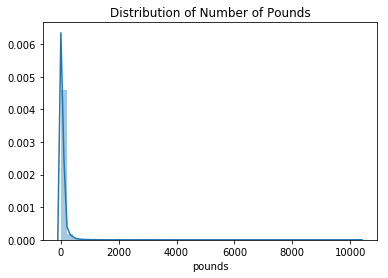

In [30]:
sns.distplot(food["pounds"]);
plt.title("Distribution of Number of Pounds");

$\text{Have a couple outliers that realy skews the data, apply a log transformation to get a better idea of what the data looks like}$

Text(0.5,0,'logged pounds')

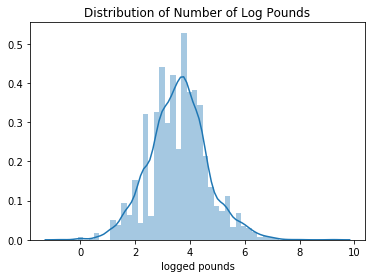

In [31]:
sns.distplot(np.log(food["pounds"]));
plt.title("Distribution of Number of Log Pounds");
plt.xlabel("logged pounds")

$\text{Distribution of logged pounds kinda looks normal with mean around 3.5, which is about 33 pounds when exponentiated}$

In [32]:
food["pounds"].median()

36.0

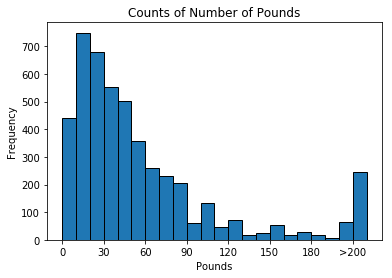

In [33]:
#plt.hist(food["pounds"], bins = range(0, 200, 10), edgecolor = "black");
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
       110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220]
food["pounds"].clip(upper = 220).plot.hist(bins = bins, edgecolor = "black");
plt.title("Counts of Number of Pounds");
ax = plt.gca()
ax.set_xticks([0, 30, 60, 90, 120, 150, 180, 210]);
ax.set_xticklabels([0, 30, 60, 90, 120, 150, 180, ">200"]);
plt.xlabel("Pounds");

$\text{About a third of the food donations are between 10-30 pounds}$

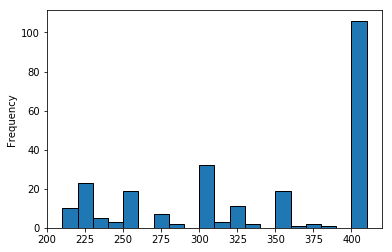

In [34]:
food["pounds"].clip(upper = 410).plot.hist(bins = range(210, 420, 10), edgecolor = "black");

### Distribution of Counts and Pounds for Dates, Size, and Type

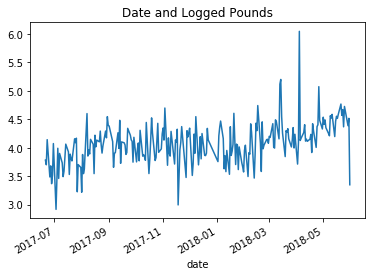

In [35]:
food["date"] = pd.to_datetime(food["date"])
np.log(food.groupby(food["date"])["pounds"].agg(np.mean)).plot();
plt.title("Date and Logged Pounds");

\begin{align*}
\\&- \text{Review how to perform time series analysis in order to demonstrate whether or not there is a trend. Fit a model and then look at distribution of residuals.}
\\&- \text{From initial glance, appears to be some seasonality (need to review fourier transform)}
\\&- \text{Appears to be an upward trend, so more food donations}
\end{align*}

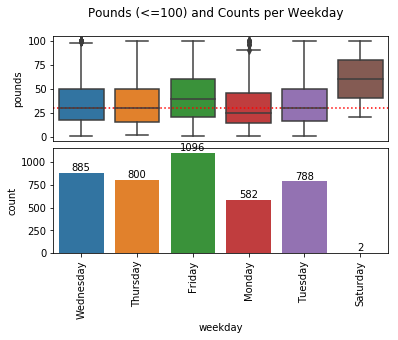

In [36]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x=food[food["pounds"] <= 100]["weekday"],
    y=food[food["pounds"] <= 100]["pounds"],
    ax=axs[0]
)

sns.countplot(
    x='weekday',
    data=food[food["pounds"] <= 100],
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y= food[food['pounds'] <= 100]["pounds"].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.07)
plt.suptitle("Pounds (<=100) and Counts per Weekday");

\begin{align*}
&- \text{Most frequent pickup day is Friday}
\\ &- \text{Of the pickups between 0 and 100 pounds of food, Fridays have a slightly higher average than the other days.}
\\ &- \text{Saturday only has 2 entries, so not very comparable to the other days.}
\end{align*}

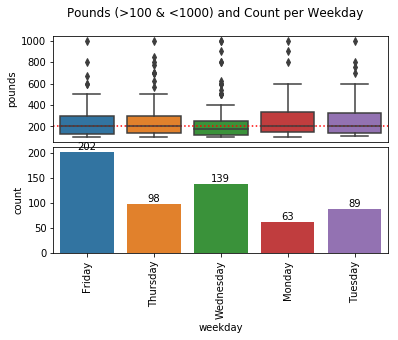

In [37]:
fig, axs = plt.subplots(nrows=2)


sns.boxplot(
    x=food[(food["pounds"] > 100) & (food["pounds"] <= 1000)]['weekday'],
    y=food[(food["pounds"] > 100) & (food["pounds"] <= 1000)]["pounds"],
    ax=axs[0]
)

sns.countplot(
    x='weekday',
    data=food[(food["pounds"] > 100) & (food["pounds"] <= 1000)],
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y= food[(food['pounds'] > 100) & (food['pounds'] <= 1000)]["pounds"].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.05)
plt.suptitle("Pounds (>100 & <1000) and Count per Weekday");

\begin{align*}
&- \text{Fridays also have the most pickups for large food pickups.}
\\ &- \text{Not much variation between the means of each of the days.}
\end{align*}

In [38]:
np.mean(food[(food["pounds"] > 100) & (food["pounds"] <= 1000)]["pounds"])

248.74901861252113

In [39]:
food[(food["pounds"] > 100) & (food["pounds"] <= 1000)].groupby("weekday")["pounds"].agg(np.mean)

weekday
Friday       230.519802
Monday       284.650794
Thursday     270.874184
Tuesday      261.179775
Wednesday    235.410072
Name: pounds, dtype: float64

$\text{Friday and Wednesday avg actually about 40 pounds lower than avg of other days}$

In [40]:
food["year"] = food["year"].astype("int")

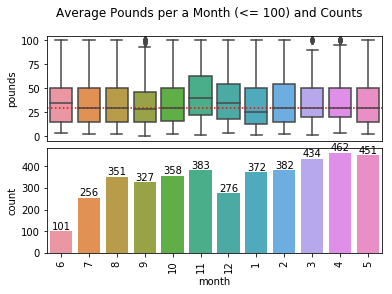

In [41]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x=food[(food["pounds"] <= 100)]['month'],
    y=food[(food["pounds"] <= 100)]["pounds"],
    ax=axs[0]
)

sns.countplot(
    x='month',
    data=food[(food["pounds"] <= 100)],
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y= food[(food["pounds"] <= 100)]["pounds"].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.07)
plt.suptitle("Average Pounds per a Month (<= 100) and Counts");

\begin{align*}
& - \text{June, November, and December have slightly higher average number of pounds being picked up between 0-100 pounds}
\\ &- \text{June was the beginning of the data collection, May was the month with the last data entry}
\end{align*}

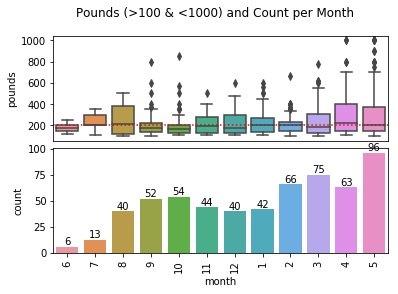

In [42]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x=food[(food['pounds'] > 100) & (food["pounds"] <=1000)]['month'],
    y=food[(food['pounds'] > 100) & (food["pounds"] <=1000)]["pounds"],
    ax=axs[0]
)

sns.countplot(
    x='month',
    data=food[(food['pounds'] > 100) & (food["pounds"] <=1000)],
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y= food[(food['pounds'] > 100) & (food["pounds"] <=1000)]["pounds"].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.07)
plt.suptitle("Pounds (>100 & <1000) and Count per Month");

\begin{align*}
& - \text{July has the highest average for number of pounds being picked up. But only has 14 pickups so probably not accurate to say that there is more food waste in July.} 
\\ & - \text{Number of large pickups shot from 63 to 96 between April and May. Is there a reasoning behind this?}  
\end{align*}

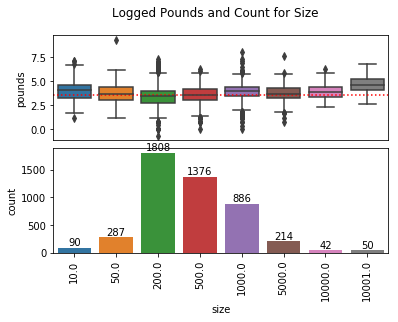

In [43]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x=food['size'],
    y=np.log(food["pounds"]),
    ax=axs[0]
)

sns.countplot(
    x='size',
    data=food,
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y= np.log(food["pounds"]).median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.07)
plt.suptitle("Logged Pounds and Count for Size");

\begin{align*}
& -\text{Larger companies (1000+) unsurprisingly has higher amount of food waste} 
\\ &-\text{Company size of 10 has a surprisingly high amount of food waste}
\\ &-\text{Appears to be downward trend and then upward trend with company size and food donation, maybe quadratic trend}
\end{align*}

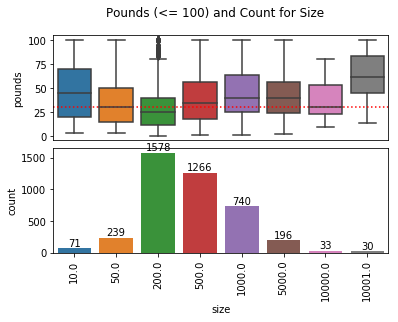

In [44]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x=food[food['pounds'] <= 100]["size"],
    y=food[food["pounds"] <= 100]["pounds"],
    ax=axs[0]
)

sns.countplot(
    x='size',
    data=food[food["pounds"] <=100],
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y= food[food["pounds"] <=100]["pounds"].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.07)
plt.suptitle("Pounds (<= 100) and Count for Size");

$\text{trend for food donation consistent with previous plot, downward trend and then upward trend}$

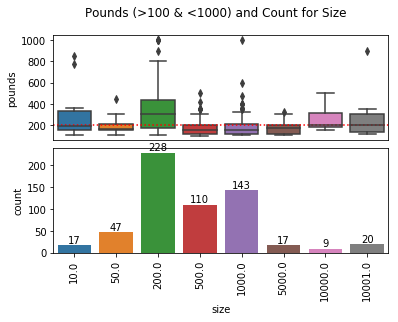

In [45]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x=food[(food['pounds'] > 100) & (food["pounds"] <=1000)]["size"],
    y=food[(food["pounds"] > 100) & (food["pounds"] <=1000)]["pounds"],
    ax=axs[0]
)

sns.countplot(
    x='size',
    data=food[(food["pounds"] >100) & (food["pounds"] <=1000)],
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y= food[(food["pounds"] >100) & (food["pounds"] <=1000)]["pounds"].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.07)
plt.suptitle("Pounds (>100 & <1000) and Count for Size");

\begin{align*}
& -\text{Large food donations mostly coming from companies with size between 50-200}
\end{align*}

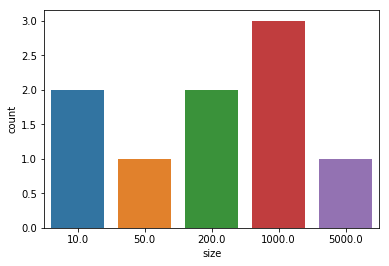

In [46]:
sns.countplot(
    x='size',
    data=food[food["pounds"] >1000],
);

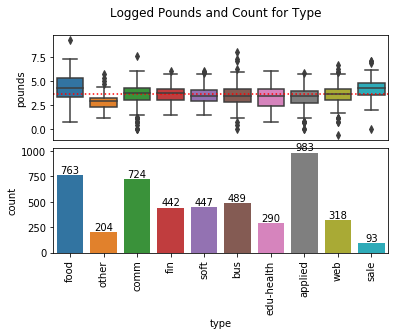

In [47]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x=food['type'],
    y=np.log(food["pounds"]),
    ax=axs[0]
)

sns.countplot(
    x='type',
    data=food,
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y= np.log(food["pounds"]).median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.07)
plt.suptitle("Logged Pounds and Count for Type");

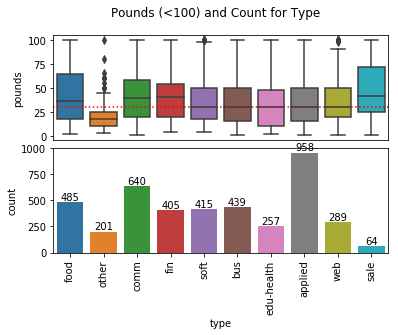

In [48]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x=food[food['pounds'] <= 100]["type"],
    y=food[food["pounds"] <= 100]["pounds"],
    ax=axs[0]
)

sns.countplot(
    x='type',
    data=food[food["pounds"] <=100],
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y= food[food["pounds"] <=100]["pounds"].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.07)
plt.suptitle("Pounds (<100) and Count for Type");

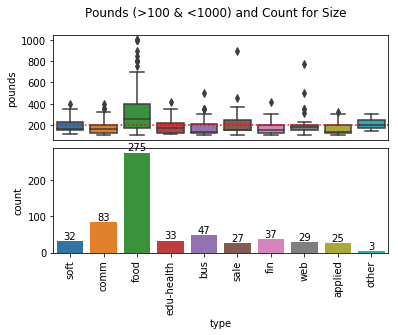

In [49]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x=food[(food['pounds'] > 100) & (food["pounds"] <=1000)]["type"],
    y=food[(food["pounds"] > 100) & (food["pounds"] <=1000)]["pounds"],
    ax=axs[0]
)

sns.countplot(
    x='type',
    data=food[(food["pounds"] >100) & (food["pounds"] <=1000)],
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y= food[(food["pounds"] >100) & (food["pounds"] <=1000)]["pounds"].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.07)
plt.suptitle("Pounds (>100 & <1000) and Count for Size");

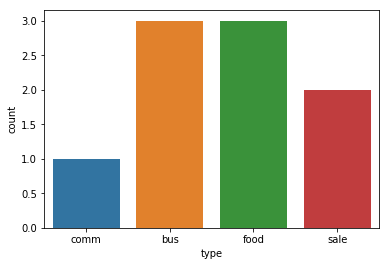

In [50]:
sns.countplot(
    x='type',
    data=food[(food["pounds"] >1000)],
);

### Heatmaps 

In [51]:
city_corr = food[["pounds", "city"]].pipe(ohe_city).corr()
state_corr = food[["pounds", "state"]].pipe(ohe_state).corr()
zip_corr = food[["pounds", "zip"]].pipe(ohe_zip).corr()
month_corr = food[["pounds", "month"]].pipe(ohe_month).corr()
day_corr = food[["pounds", "day"]].pipe(ohe_day).corr()
year_corr = food[["pounds", "year"]].pipe(ohe_year).corr()
weekday_corr = food[["pounds", "weekday"]].pipe(ohe_weekday).corr()

c:\users\jordan fan\anaconda3\envs\toxic\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\jordan fan\anaconda3\envs\toxic\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\jordan fan\anaconda3\envs\toxic\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

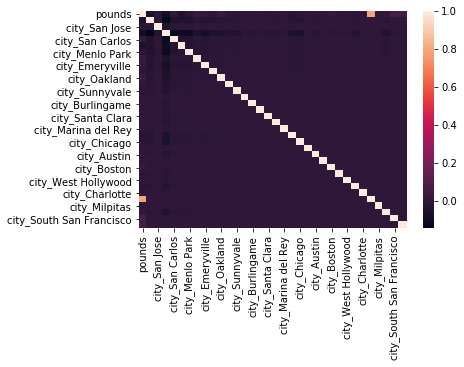

In [52]:
sns.heatmap(city_corr);


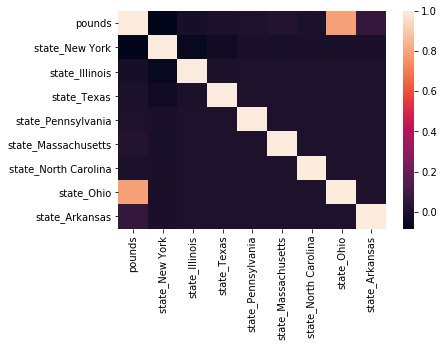

In [53]:
sns.heatmap(state_corr);


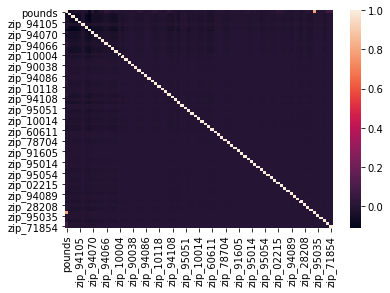

In [54]:
sns.heatmap(zip_corr);

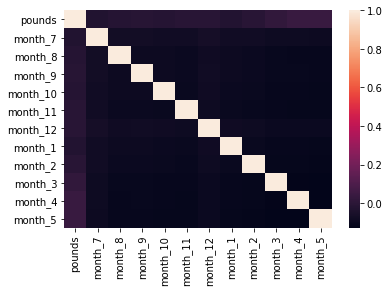

In [55]:
sns.heatmap(month_corr);


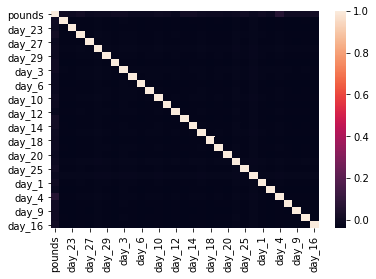

In [56]:
sns.heatmap(day_corr);


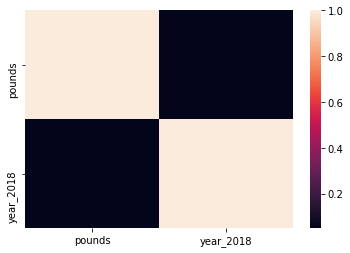

In [57]:
sns.heatmap(year_corr);


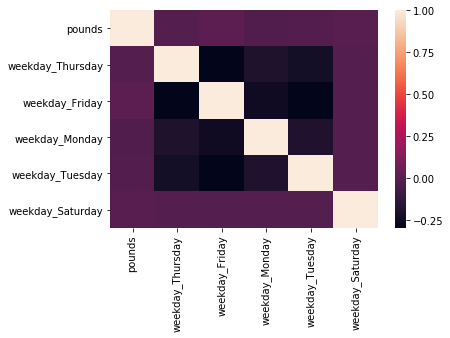

In [58]:
sns.heatmap(weekday_corr);

In [59]:
mean_totals = food.groupby("date")["pounds"].agg(np.mean).sort_values(ascending = False)
mean_totals.head(60)

date
2018-04-04    422.250000
2018-03-14    181.320000
2018-03-13    166.875000
2018-04-26    159.703704
2018-05-21    117.666667
2018-02-16    114.583333
2018-05-25    112.800000
2017-11-03    109.740741
2018-05-23    106.703704
2018-01-20    100.000000
2017-08-07     99.512222
2018-05-11     98.171429
2018-05-18     98.142857
2018-05-22     96.526316
2018-05-09     95.838621
2018-05-16     95.000000
2018-03-15     94.388889
2017-12-08     94.314286
2017-08-30     94.312778
2018-05-01     93.400000
2017-10-19     92.277778
2018-05-10     91.904762
2018-05-30     91.555556
2018-05-17     91.500000
2018-03-08     89.204545
2018-05-03     89.090909
2018-04-27     88.533333
2017-09-13     88.421053
2018-01-05     87.285714
2018-05-15     87.125000
2018-03-09     86.655172
2018-02-21     86.043478
2017-10-13     85.166667
2018-02-14     84.047619
2017-10-26     83.850000
2018-03-05     83.333333
2018-04-19     83.250000
2018-02-08     83.111111
2018-05-02     82.444444
2018-04-10     81.90

Doesn't seem to be much of a pattern by the date and when there is the most food. May does appear a lot tho. 14 of the top 30 highest average pounds are in May. 

### Looking at Most Frequent Donators 

In [60]:
food["company"].value_counts()

Twitch                       437
Dataminr                     429
Zoox                         306
Lever                        203
ZeroCater                    199
Zesty SF                     193
GoFundMe                     177
Drone Deploy                 128
DoorDash                     117
Livongo                      115
CircleCI                     104
Vungle SF                     90
Pagerduty                     89
Pierry Inc.                   88
EAT Club                      85
OpenDNS                       82
Scribd                        80
Dropbox                       77
Opendoor                      74
Flexport NYC                  71
Omada Health                  69
Trello 25th Floor             68
Tumblr NYC Office             62
Compass Headquarters          59
YieldMo                       54
MuleSoft                      52
Fare Resources                48
Moogsoft, Inc.                47
Aera Technology Inc.          44
Metromile                     42
          

Twitch and Dataminr are the companies that have the most pickups. Observe whether or not the pickups have gotten bigger over time

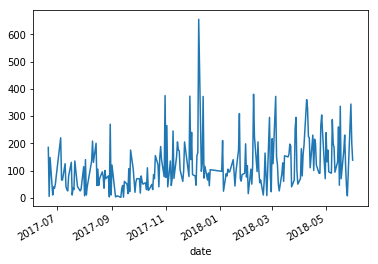

In [61]:
twitch = food[food["company"] == "Twitch"].groupby("date")["pounds"].agg(np.sum)
twitch.plot();

In [62]:
food["type"].value_counts()

applied       983
food          763
comm          724
bus           489
soft          447
fin           442
web           318
edu-health    290
other         204
sale           93
Name: type, dtype: int64

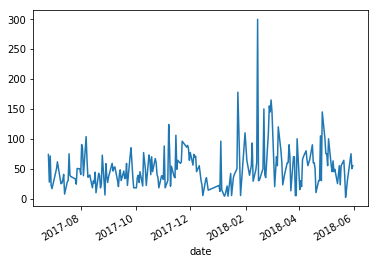

In [63]:
food[food["company"] == "Dataminr"].groupby("date")["pounds"].agg(np.sum).plot();

### Other Plots

351     6
352     6
353     6
354     6
355     6
356     6
359     6
368     6
369     6
370     6
372     6
375     6
376     6
377     6
378     6
379     6
380     6
381     6
382     6
383     6
384     6
385     6
386     6
387     6
390     6
391     6
392     6
393     6
394     6
395     6
       ..
6485    5
6486    5
6487    5
6490    5
6491    5
6494    5
6495    5
6497    5
6498    5
6500    5
6501    5
6502    5
6503    5
6504    5
6507    5
6509    5
6511    5
6512    5
6513    5
6516    5
6518    5
6520    5
6521    5
6528    5
6529    5
6532    5
6533    5
6534    5
6535    5
6578    5
Name: month, Length: 4753, dtype: int64

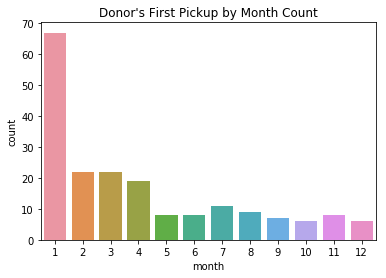

In [79]:
food["month"] = pd.to_numeric(food["month"])
sns.countplot(food.groupby("company")["month"].agg(np.min));
plt.title("Donor's First Pickup by Month Count");

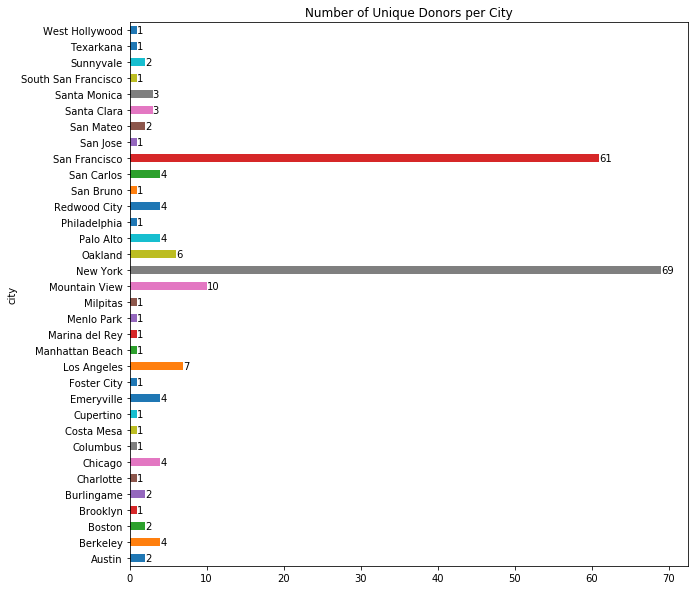

In [80]:
city_companies = food.groupby("city")["company"].unique().agg(len)
city_companies.plot(kind = "barh", figsize = (10,10), 
                   title = "Number of Unique Donors per City")
for y, x in enumerate(city_companies):
    plt.annotate(str(x), xy = (x, y), va = "center")

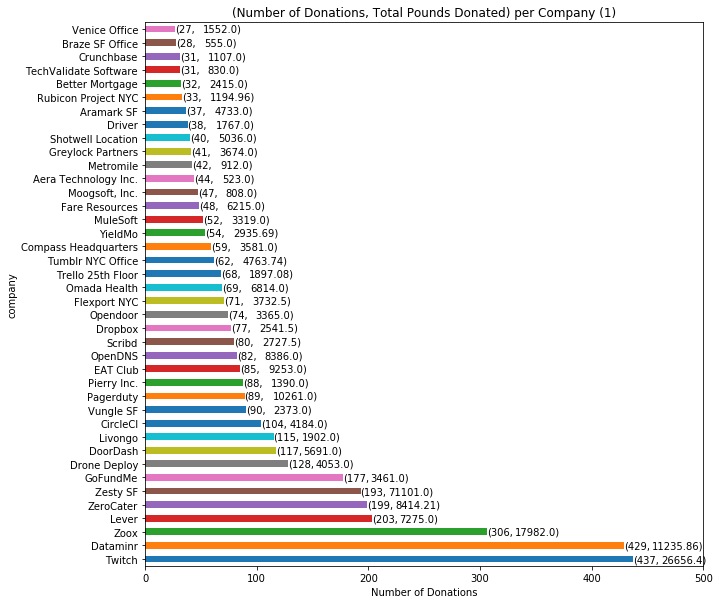

In [81]:
donor_counts = food.groupby("company")["pounds"].count().sort_values(ascending = False)
donor_pounds = food.groupby("company")["pounds"].agg(np.sum)
donor_pounds = donor_pounds.reindex(index = donor_counts.index)
ax1 = donor_counts[0:40].plot(kind = "barh", figsize = (10,10),
                       title = "(Number of Donations, Total Pounds Donated) per Company (1)")
for a, b in zip(enumerate(donor_counts[0:40]), enumerate(donor_pounds[0:40])):
    plt.annotate("(" + str(a[1]) + ",", xy = (a[1], a[0]), va = "center")
    plt.annotate(str(round(b[1],2)) + ")", xy = (a[1] + 25, a[0]), va = "center")
ax1.set_xlim(0,500);
plt.xlabel("Number of Donations");

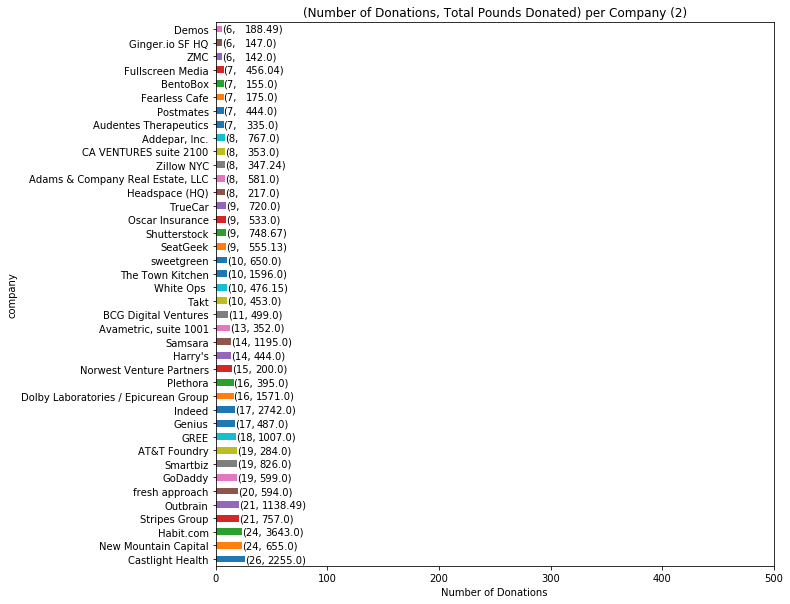

In [82]:
ax2 = donor_counts[40:80].plot(kind = "barh", figsize = (10,10),
                       title = "(Number of Donations, Total Pounds Donated) per Company (2)")
for a, b in zip(enumerate(donor_counts[40:80]), enumerate(donor_pounds[40:80])):
    plt.annotate("(" + str(a[1]) + ",", xy = (a[1], a[0]), va = "center")
    plt.annotate(str(round(b[1],2)) + ")", xy = (a[1] + 20, a[0]), va = "center")
ax2.set_xlim(0,500);
plt.xlabel("Number of Donations");

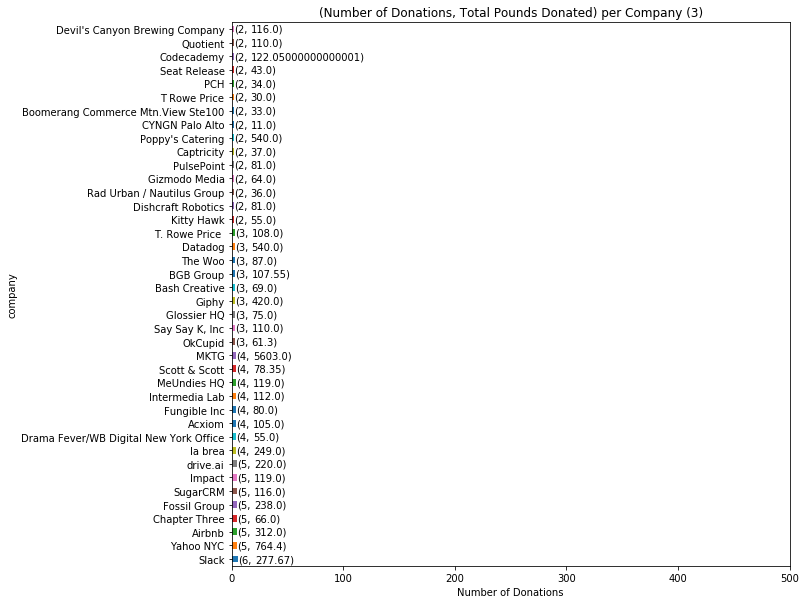

In [83]:
ax3 = donor_counts[80:120].plot(kind = "barh", figsize = (10,10),
                       title = "(Number of Donations, Total Pounds Donated) per Company (3)")
for a, b in zip(enumerate(donor_counts[80:120]), enumerate(donor_pounds[80:120])):
    plt.annotate("(" + str(a[1]) + ",", xy = (a[1], a[0]), va = "center")
    plt.annotate(str(b[1]) + ")", xy = (a[1] + 15, a[0]), va = "center")
ax3.set_xlim(0,500);
plt.xlabel("Number of Donations");

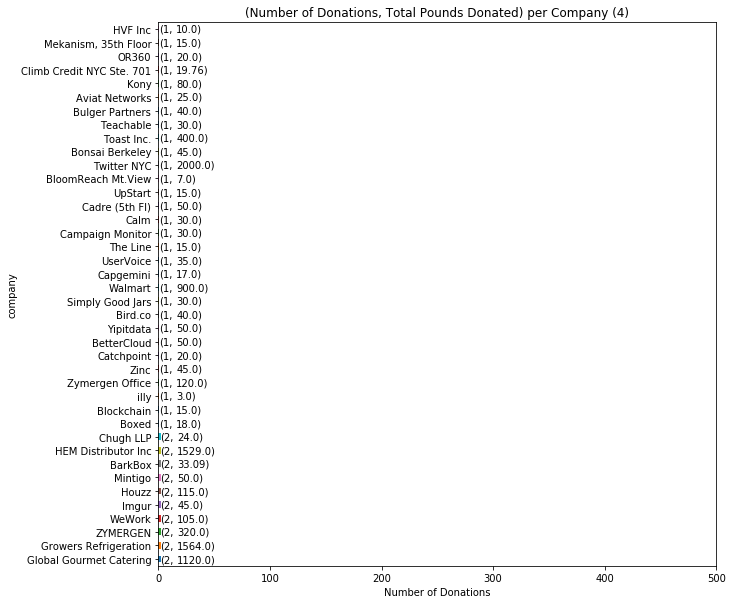

In [84]:
ax4 = donor_counts[120:160].plot(kind = "barh", figsize = (10,10),
                       title = "(Number of Donations, Total Pounds Donated) per Company (4)")
for a, b in zip(enumerate(donor_counts[120:160]), enumerate(donor_pounds[120:160])):
    plt.annotate("(" + str(a[1]) + ",", xy = (a[1], a[0]), va = "center")
    plt.annotate(str(round(b[1],2)) + ")", xy = (a[1] + 15, a[0]), va = "center")
ax4.set_xlim(0,500);
plt.xlabel("Number of Donations");

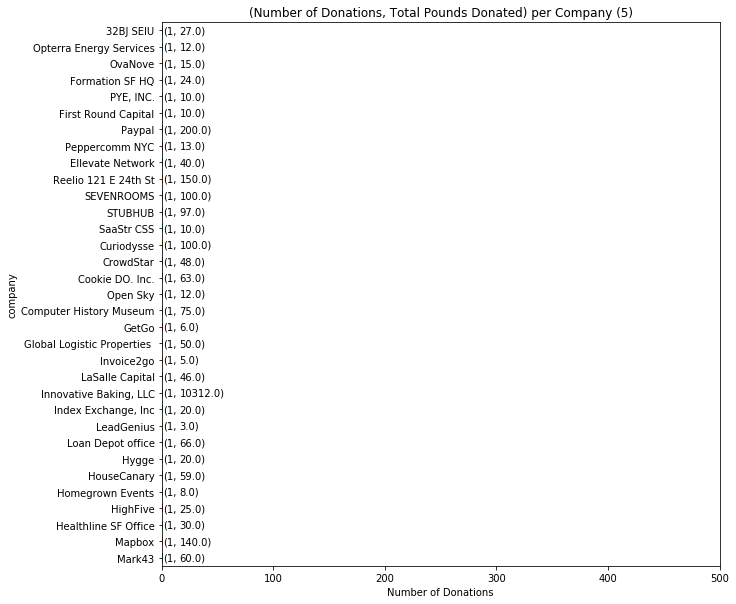

In [85]:
ax5 = donor_counts[160:].plot(kind = "barh", figsize = (10,10),
                       title = "(Number of Donations, Total Pounds Donated) per Company (5)")
for a, b in zip(enumerate(donor_counts[160:]), enumerate(donor_pounds[160:])):
    plt.annotate("(" + str(a[1]) + ",", xy = (a[1], a[0]), va = "center")
    plt.annotate(str(round(b[1],2)) + ")", xy = (a[1] + 15, a[0]), va = "center")
ax5.set_xlim(0,500);
plt.xlabel("Number of Donations");

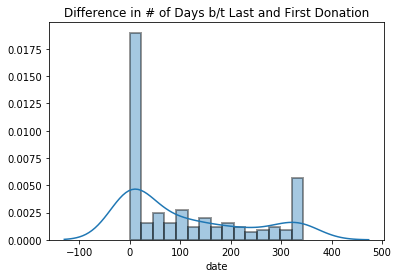

In [86]:
sns.distplot(food.groupby("company")["date"].agg(lambda x: (max(x) - min(x)).days).sort_values(), bins = 15, hist_kws=dict(edgecolor="k", linewidth=2));
plt.title("Difference in # of Days b/t Last and First Donation");

- number of donors that have consistently donated and the longetivity of their donations 
- average time that donors donate until they stop. 


In [87]:
food[food["company"] == "Acxiom"]

,Id,date,pounds,id,number,street,city,company,state,zip,lat,lon,pickup,planned,month,day,year,weekday,size,type
3957,4076,2018-02-01,50.0,380,2,West 17th Street,New York,Acxiom,New York,10011,40.738027,-73.992672,20,False,2,1,2018,Thursday,5000.0,bus
5399,5558,2018-04-12,20.0,380,2,West 17th Street,New York,Acxiom,New York,10011,40.738027,-73.992672,20,False,4,12,2018,Thursday,5000.0,bus
5722,5882,2018-04-26,10.0,380,2,West 17th Street,New York,Acxiom,New York,10011,40.738027,-73.992672,20,False,4,26,2018,Thursday,5000.0,bus
6168,6328,2018-05-15,25.0,380,2,West 17th Street,New York,Acxiom,New York,10011,40.738027,-73.992672,20,False,5,15,2018,Tuesday,5000.0,bus


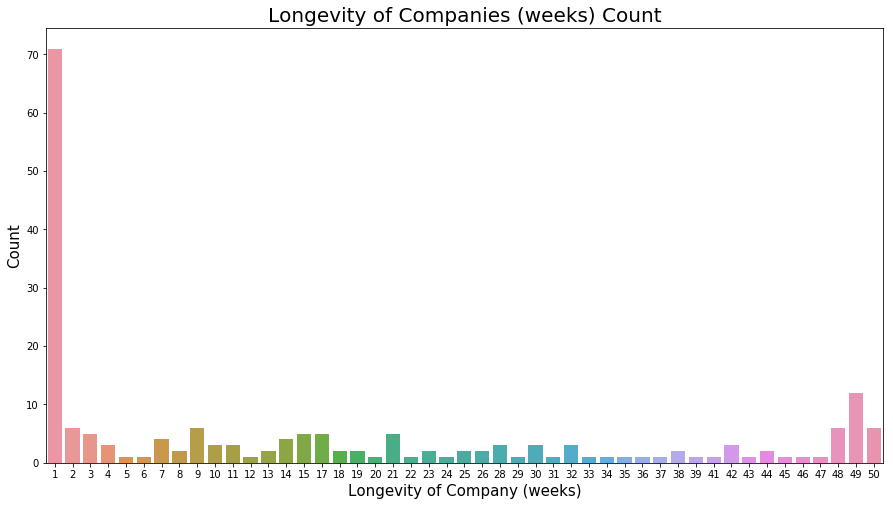

In [88]:
plt.figure(figsize = (15, 8))
sns.countplot(food.groupby("company")["date"].agg(lambda x: int((max(x) - min(x))/np.timedelta64(1, "W")))+ 1);
plt.xlabel("Longevity of Company (weeks)", fontsize = 15);
plt.ylabel("Count", fontsize = 15);
plt.title("Longevity of Companies (weeks) Count", fontsize = 20);

In [177]:
food.groupby(["company", "month"])["pounds"].agg(np.mean)

company                           month
32BJ SEIU                         9         27.000000
AT&T Foundry                      3         27.000000
                                  4         10.444444
                                  5         17.000000
Acxiom                            2         50.000000
                                  4         15.000000
                                  5         25.000000
Adams & Company Real Estate, LLC  1         27.666667
                                  2        200.000000
                                  3        100.000000
                                  4        100.000000
                                  12        49.000000
Addepar, Inc.                     2        150.000000
                                  3         62.666667
                                  5         93.000000
Aera Technology Inc.              1         11.750000
                                  2          7.250000
                                  3       

In [204]:
company_weeks = food.groupby("company")["date"].agg(lambda x: int((max(x) - min(x))/np.timedelta64(1, "W")))+ 1
company_tot_donation = food.groupby("company")["pounds"].agg(np.sum)
company_num_donation = food.groupby("company")["pounds"].count()
company_one_donation = (company_num_donation == 1).astype("int")
company_pound_per_week = company_tot_donation/company_weeks
company_avg_donation = company_tot_donation/company_num_donation
company_max_donation = food.groupby("company")["pounds"].agg(np.max)
company_med_donation = food.groupby("company")["pounds"].agg(np.median)
company_size = food.groupby("company")["size"].first()
company_type = food.groupby("company")["type"].first()
company_city = food.groupby("company")["city"].first()
company_state = food.groupby("company")["state"].first()
company_most_donation_weekday = food.groupby("company")["weekday"].agg(lambda x: np.argmax(x.value_counts()))
company_most_donation_weekday_frac = food.groupby("company")["weekday"].agg(lambda x: np.max(x.value_counts()))/company_num_donation
company_max_weekday = food[["company", "weekday", "pounds"]].groupby("company").agg(np.max)["weekday"]
company_most_donation_month = food.groupby("company")["month"].agg(lambda x: np.argmax(x.value_counts()))
company_most_donation_month_frac = food.groupby("company")["month"].agg(lambda x: np.max(x.value_counts()))/company_num_donation
company_start_month = food.groupby("company")["month"].agg(np.min)
company = pd.DataFrame({#"tot_donation": company_tot_donation, 
                       "num_donation": company_num_donation, 
                        "num_weeks": company_weeks, 
                       #"avg_donation": company_avg_donation, 
                        "week_donation": company_pound_per_week,
                       #"max_donation": company_max_donation, 
                        #"med_donation": company_med_donation,
                        "size": company_size, "type": company_type,
                       "popular_weekday": company_most_donation_weekday,
                        "popular_month": company_most_donation_month,
                       "popular_weekday_frac": company_most_donation_weekday_frac,
                        "popular_month_frac": company_most_donation_month_frac,
                       "max_pound_weekday": company_max_weekday, "start_month": company_start_month,
                        "one_donation": company_one_donation, "state": company_state
                       })
#company_tot_donation/company_weeks

c:\users\jordan fan\anaconda3\envs\toxic\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [195]:
def ohe_max_pound_weekday(data):
    cats = data["max_pound_weekday"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data['max_pound_weekday'] = data['max_pound_weekday'].astype(cat_type)
    data = pd.get_dummies(data,
                    prefix='max_weekday',
                    columns=['max_pound_weekday'], 
                    drop_first=True)
    return data

def ohe_popular_month(data):
    cats = data["popular_month"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data["popular_month"] = data['popular_month'].astype(cat_type)
    data = pd.get_dummies(data,
                    prefix='pop_month',
                    columns=['popular_month'], 
                    drop_first=True)
    return data
    
def ohe_popular_weekday(data):
    cats = data["popular_weekday"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data['popular_weekday'] = data['popular_weekday'].astype(cat_type)
    data = pd.get_dummies(data,
                    prefix='pop_weekday',
                    columns=['popular_weekday'], 
                    drop_first=True)
    return data

def ohe_size(data): 
    cats = data["size"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data['size'] = data['size'].astype(cat_type)
    data = pd.get_dummies(data,
                    prefix='size',
                    columns=['size'], 
                    drop_first=True)
    return data

def ohe_start_month(data):
    cats = data["start_month"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data['start_month'] = data['start_month'].astype(cat_type)
    data = pd.get_dummies(data,
                    prefix='start_month',
                    columns=['start_month'], 
                    drop_first=True)
    return data

def ohe_state(data):
    cats = data["state"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data['state'] = data['state'].astype(cat_type)
    data = pd.get_dummies(data,
                    prefix='state',
                    columns=['state'], 
                    drop_first=True)
    return data

def ohe_type(data):
    cats = data["type"].unique().tolist()
    cat_type = CategoricalDtype(categories=cats)
    data['type'] = data['type'].astype(cat_type)
    data = pd.get_dummies(data,
                    prefix='type',
                    columns=['type'], 
                    drop_first=True)
    return data

def process_data(data):
    data = (
        data
        # Clean Data
        .pipe(ohe_max_pound_weekday)
        .pipe(ohe_popular_month)
        .pipe(ohe_popular_weekday)
        .pipe(ohe_size)
        .pipe(ohe_start_month)
        .pipe(ohe_state)
        .pipe(ohe_type)
    )
    return data
process_data(company).to_csv("avg_week_donation.csv", sep = ",")
#food.to_csv("replate_updated_updated.csv", sep = ",")

In [199]:
process_data(company)

,one_donation,popular_month_frac,popular_weekday_frac,week_donation,max_weekday_Wednesday,max_weekday_Tuesday,max_weekday_Friday,max_weekday_Thursday,max_weekday_Saturday,pop_month_4,...,state_Arkansas,type_comm,type_bus,type_fin,type_applied,type_sale,type_food,type_edu-health,type_web,type_soft
company,,,,,,,,,,,,,,,,,,,,,
32BJ SEIU,1,1.000000,1.000000,27.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT&T Foundry,0,0.473684,0.526316,25.818182,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
Acxiom,0,0.500000,0.750000,7.000000,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
"Adams & Company Real Estate, LLC",0,0.375000,0.250000,32.277778,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
"Addepar, Inc.",0,0.375000,1.000000,51.133333,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Aera Technology Inc.,0,0.113636,0.977273,10.673469,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Airbnb,0,0.400000,0.600000,22.285714,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Aramark SF,0,0.135135,1.000000,96.591837,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Audentes Therapeutics,0,0.428571,0.428571,12.884615,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [213]:
x = process_data(company).drop("week_donation", axis = 1)
y = company["week_donation"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 12351)


In [219]:
clf = linear_model.Lasso()
clf.fit(x_train, y_train)
print(clf.get_params())

{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
